In [1]:
import numpy as np
import os
from PIL import Image, features
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import torch
import tensorflow as tf
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from ae import AutoEncoder

from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/introduction')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using the device",device)

%reload_ext autoreload
%autoreload 2


Using the device cuda:0


In [2]:
from random import randint
def take_random_tile(img_raw,tile_size=8,sample_shape_range=None):
    channels, width,height=list(img_raw.shape) #(3,width,height)

    if sample_shape_range != None:
        min_size, max_size = sample_shape_range

        tile_size = randint(min_size,max_size)

        if tile_size > width or tile_size > height: #correct for sample sizes bigger than the image
            tile_size = min(height,width)
    
    top  = randint(0,width-tile_size)
    left = randint(0,height-tile_size)

    tile_tensor = img_raw[:,top:top+tile_size,left:left+tile_size] #tile
    #print(list(tile_tensor.shape))

    if sample_shape_range != None:
        tile_tensor = F.interpolate(tile_tensor,size=(channels,tile_size,tile_size))
    return tile_tensor
    


In [3]:
from random import sample
def get_tile_batch(image_list, batch_size=1000, tile_size=8, sample_shape_range=None):
    convert_tensor = transforms.ToTensor()
    while True:
        tile_list = [] #initialize batch tensor
        for i in range(batch_size):
            next_image,=sample(image_list,k=1)
            #print(next_image)
            image_tensor = convert_tensor(Image.open(next_image).convert('RGB'))
            
            tile = take_random_tile(image_tensor,tile_size=8)
            #print(tile.shape)
            tile_list.append(tile)

        batch = torch.stack(tile_list)
        yield batch

In [4]:
from os import listdir
from os.path import isdir, join

wd_path = os.path.abspath(os.getcwd())
root_path = os.path.join(wd_path, "datasets", 'ImageNet','train')

# Mean and standard deviations have to be sequences (e.g. tuples),hence we add a comma after the values
#transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]) 
#imageNet_dataset = torchvision.datasets.ImageFolder(root=root_path,transform=transform)
#imageNet_dataloader = DataLoader(imageNet_dataset, batch_size=1000)

image_path_list = []
for d in listdir(root_path):
    #d = n016...
    class_path = join(root_path,d,"images")
    for i in listdir(class_path):
        #i = n016..._n.JPEG
        image_path_list.append(join(class_path,i))

batch_maker = get_tile_batch(image_path_list,batch_size=10)


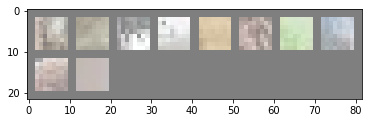

In [14]:
def imshow(img):
    img = img / 2 + 0.5 # unormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
sample_images = next(batch_maker)

# show images
imshow(torchvision.utils.make_grid(sample_images))
# print labels

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self, activation=nn.ReLU(),
                 input_size=3*8*8, hidden_sizes=[32*3,8,32*3]):
        super(AutoEncoder, self).__init__()
        self.input_size = input_size

        # Here we initialize our activation and set up our two linear layers
        self.activation = activation
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], input_size)


    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)

        return x
    
    def encode(self,x):
        x = x.view(-1, 3*8*8)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)

        return x
    
    def decode(self,x):        
        x = self.activation(x)
        x = self.fc3(x)        
        x = self.activation(x)
        x = self.fc4(x)

        return x


In [25]:
def train_autoencoder(epoch_size, train_loader,optimizer,model,criterion,max_epochs):
    training_loss_history= []
    loss = 0

    for epoch_number,tiles in enumerate(train_loader):

        # reshape mini-batch data to [N, 3*8*8] matrix
        # load it to the active device
        tiles = tiles.to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        outputs = model(tiles)                 # compute reconstructions
        train_loss = criterion(outputs, tiles.view(-1, 3*8*8)) # compute training reconstruction loss
        train_loss.backward()                  # compute accumulated gradients
        optimizer.step()                       # perform parameter update based on current gradients
        loss += train_loss.item()              # add the mini-batch training loss to epoch loss
        
        if epoch_number%epoch_size == epoch_size-1:
            # compute the epoch training loss
            loss = loss / epoch_size

            # display the epoch training loss
            print(f"epoch : {(epoch_number+1)/epoch_size}, loss = {loss:.6f}")
            training_loss_history.append(loss)
            loss = 0
            if(epoch_number >= max_epochs):
                return training_loss_history
    return training_loss_history

In [ ]:
net = AutoEncoder()
net.to(device)
batch_maker = get_tile_batch(image_path_list,batch_size=1000)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [ ]:
res = train_autoencoder(20, batch_maker, optimizer, net, criterion,max_epochs=400)

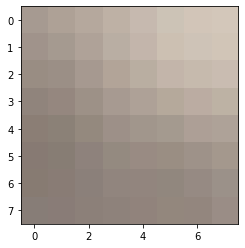

Original


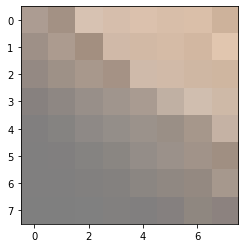

In [54]:
# get some random training images
batch_maker = get_tile_batch(image_path_list,batch_size=10)
images = next(batch_maker)

images = images.to(device)

x_r = net.encode(images[0].view(3*8*8))
x_rebuilt_r = net.decode(x_r).detach().cpu().view(3,8,8)


# show images
imshow(torchvision.utils.make_grid(x_rebuilt_r))
print("Original")
imshow(images[0].detach().cpu().view(3,8,8))
# print labels